# Práctica   7  Pronósticos modelo ARIMA
- Profesor: Daniel Jiménez Alcantar
- Alumnos:
  - Arteaga Gonzalez Edwin Yahir.
  - Juarez Gaona Erick Rafael.
  - Rico Gaytan Diana Andrea.
  - Ruiz Merino Wendy Ivonne.


## Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("archive/kalimati_tarkari_dataset.csv")
df.head()

,SN,Commodity,Date,Unit,Minimum,Maximum,Average
0,0,Tomato Big(Nepali),2013-06-16,Kg,35.0,40.0,37.5
1,1,Tomato Small(Local),2013-06-16,Kg,26.0,32.0,29.0
2,2,Potato Red,2013-06-16,Kg,20.0,21.0,20.5
3,3,Potato White,2013-06-16,Kg,15.0,16.0,15.5
4,4,Onion Dry (Indian),2013-06-16,Kg,28.0,30.0,29.0


In [5]:
print(df.columns)

Index(['SN', 'Commodity', 'Date', 'Unit', 'Minimum', 'Maximum', 'Average'], dtype='object')


In [6]:
print(df.dtypes)

SN             int64
Commodity     object
Date          object
Unit          object
Minimum      float64
Maximum      float64
Average      float64
dtype: object


In [7]:
print(df.nunique())

SN           197161
Commodity       132
Date           2753
Unit              4
Minimum         198
Maximum         205
Average         384
dtype: int64


In [8]:
df["Unit"].unique()

array(['Kg', 'Doz', '1 Pc', 'KG'], dtype=object)

In [9]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date")

In [10]:
print(df["Date"].min() , df["Date"].max())

2013-06-16 00:00:00 2021-05-13 00:00:00


In [11]:
df.groupby('Commodity')["Date"].agg(['min', 'max'])

,min,max
Commodity,,
Apple(Fuji),2019-05-31,2021-05-13
Apple(Jholey),2013-06-16,2021-05-12
Arum,2013-06-25,2021-05-13
Asparagus,2013-06-16,2021-05-13
Bakula,2013-09-29,2021-04-27
...,...,...
Turnip,2013-06-16,2021-04-27
Turnip A,2013-06-16,2021-05-13
Water Melon(Dotted),2019-06-04,2021-04-29


In [12]:

def fechas_consecutivas(fechas):
    fechas_ordenadas = fechas.sort_values()
    rango_completo = pd.date_range(start=fechas_ordenadas.min(), end=fechas_ordenadas.max(), freq='D')
    return len(fechas_ordenadas) == len(rango_completo)

# Aplicar por cada fruta
resultado = df.groupby('Commodity')['Date'].apply(fechas_consecutivas).reset_index()
resultado.columns = ['Commodity', 'fechas_consecutivas']

<AxesSubplot:title={'center':'Precio Diario de Tomato Small(Local)'}, xlabel='Date'>

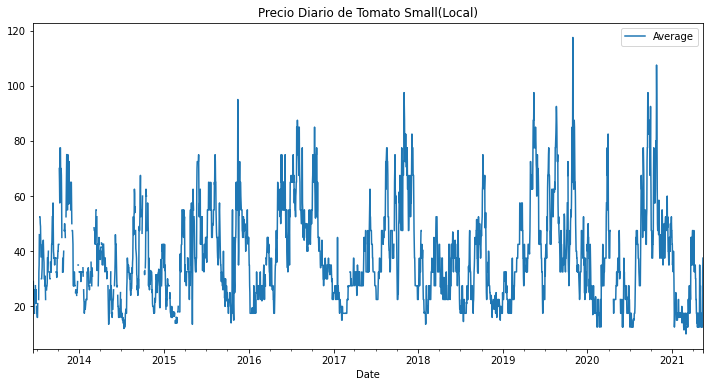

In [13]:
serie = df[(df['Commodity'] == 'Tomato Small(Local)')]
serie = serie[['Date', 'Average']].set_index('Date').asfreq('D')  # Puede requerir interpolación
serie.plot(title="Precio Diario de Tomato Small(Local)", figsize=(12, 6))

In [14]:
serie = serie.loc['2016-01-01':"2020-01-01"]

In [15]:
print(serie.isnull().sum())

Average    18
dtype: int64


In [16]:
serie['Average'] = serie['Average'].fillna(serie['Average'].rolling(window=7, min_periods=1, center=True).mean())

C:\Users\edwin\AppData\Local\Temp/ipykernel_3044/729602165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['Average'] = serie['Average'].fillna(serie['Average'].rolling(window=7, min_periods=1, center=True).mean())


In [17]:
serie.isnull().sum()

Average    0
dtype: int64

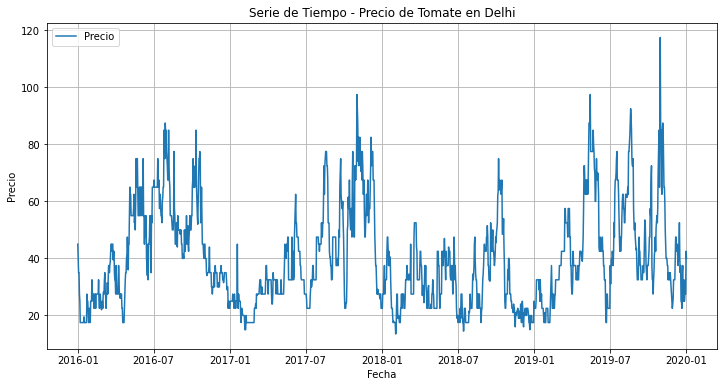

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(serie.index, serie['Average'], label='Precio')
plt.title('Serie de Tiempo - Precio de Tomate en Delhi')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
from statsmodels.tsa.stattools import adfuller

resultado_adf = adfuller(serie['Average'])
print(f"ADF Statistic: {resultado_adf[0]}")
print(f"p-value: {resultado_adf[1]}")

ADF Statistic: -5.740944317390982
p-value: 6.277792449944104e-07


<Figure size 720x288 with 0 Axes>

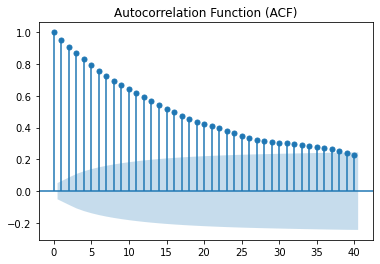

<Figure size 720x288 with 0 Axes>

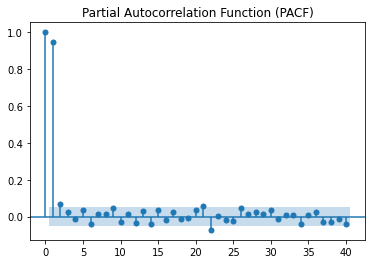

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF (para estimar q)
plt.figure(figsize=(10, 4))
plot_acf(serie['Average'], lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF (para estimar p)
plt.figure(figsize=(10, 4))
plot_pacf(serie['Average'], lags=40, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [21]:
from statsmodels.tsa.arima.model import ARIMA

# Probar distintas combinaciones
resultados = []

for p in range(0, 4):
    for q in range(0, 4):
        try:
            modelo = ARIMA(serie['Average'], order=(p, 0, q))
            modelo_ajustado = modelo.fit()
            resultados.append({
                'p': p,
                'q': q,
                'AIC': modelo_ajustado.aic,
                'BIC': modelo_ajustado.bic
            })
        except:
            continue

# Mostrar resultados ordenados por AIC
import pandas as pd
resultados_df = pd.DataFrame(resultados).sort_values(by='AIC')
print(resultados_df)


c:\Users\edwin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\edwin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


    p  q           AIC           BIC
13  3  1   9125.886036   9157.611400
10  2  2   9126.355639   9158.081003
14  3  2   9127.442507   9164.455431
11  2  3   9127.882955   9164.895880
15  3  3   9128.774029   9171.074514
5   1  1   9134.571767   9155.722009
8   2  0   9134.862261   9156.012504
12  3  0   9136.085578   9162.523381
6   1  2   9136.177420   9162.615224
9   2  1   9136.279081   9162.716884
7   1  3   9137.822384   9169.547747
4   1  0   9139.661560   9155.524241
3   0  3   9940.653262   9967.091065
2   0  2  10403.713659  10424.863902
1   0  1  11063.207921  11079.070602
0   0  0  12485.920968  12496.496089


c:\Users\edwin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
from statsmodels.tsa.arima.model import ARIMA


modelo = ARIMA(serie['Average'], order=(3, 0, 1))
modelo_ajustado = modelo.fit()


print(modelo_ajustado.summary())

                               SARIMAX Results                                
Dep. Variable:                Average   No. Observations:                 1462
Model:                 ARIMA(3, 0, 1)   Log Likelihood               -4556.943
Date:                Sun, 11 May 2025   AIC                           9125.886
Time:                        20:07:48   BIC                           9157.611
Sample:                    01-01-2016   HQIC                          9137.720
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.0278      3.596     11.131      0.000      32.980      47.076
ar.L1         -0.0450      0.037     -1.212      0.225      -0.118       0.028
ar.L2          0.8546      0.036     23.571      0.0

c:\Users\edwin\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


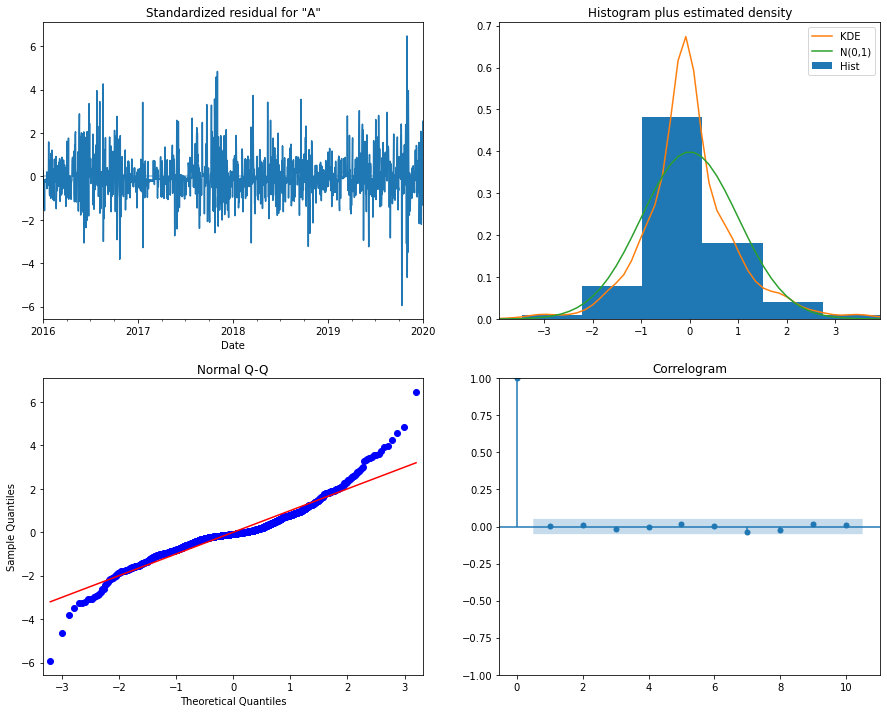

In [23]:
modelo_ajustado.plot_diagnostics(figsize=(15, 12))
plt.show()

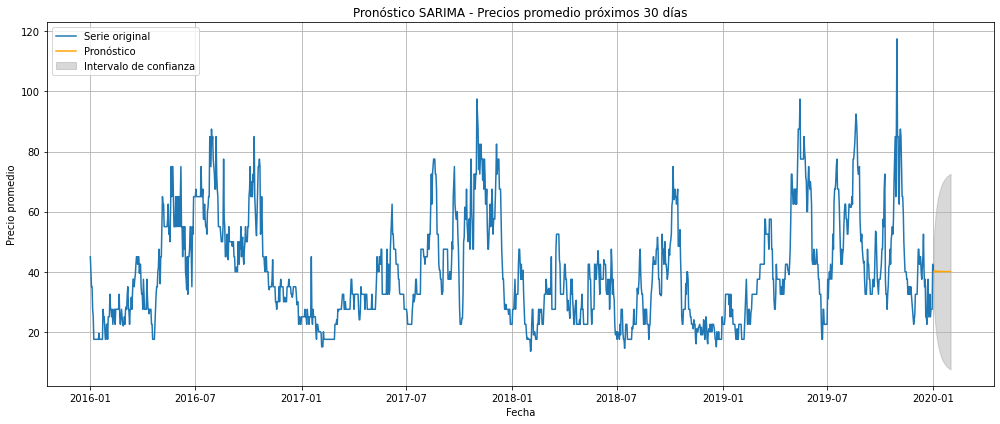

In [24]:

forecast = modelo_ajustado.get_forecast(steps=30)


forecast_df = forecast.summary_frame()


import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(serie.index, serie['Average'], label='Serie original')
plt.plot(forecast_df.index, forecast_df['mean'], label='Pronóstico', color='orange')
plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='gray', alpha=0.3, label='Intervalo de confianza')
plt.title('Pronóstico SARIMA - Precios promedio próximos 30 días')
plt.xlabel('Fecha')
plt.ylabel('Precio promedio')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
